In [ ]:
library(tidyverse)
library(naniar)
library(visdat)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(GGally)
library(corrr)
library(dplyr)
library(car)
library(mgcv)
library(ggfortify)

### 1. Initial data load and feature subset/tranform etc. 

In [3]:
data = read.csv('data/fatal-police-shootings-data.csv', na.strings=c("","NA"))

In [4]:
dim(data)
names(data)

[1] 7291   19

[1] "id"                      "name"                   
 [3] "date"                    "manner_of_death"        
 [5] "armed"                   "age"                    
 [7] "gender"                  "race"                   
 [9] "city"                    "state"                  
[11] "signs_of_mental_illness" "threat_level"           
[13] "flee"                    "body_camera"            
[15] "longitude"               "latitude"               
[17] "is_geocoding_exact"      "smha_exp_per_capita"    
[19] "smi_prevalance"

#### Drop features as necessary

In [5]:
features_to_keep = c("date","armed","age","gender","race","state","flee","body_camera","signs_of_mental_illness")
data = data[, (names(data) %in% features_to_keep)]

#### Convert features to desired datatypes

In [6]:
factor_cols = c("armed", "gender", "race", "state", "flee", "body_camera", "signs_of_mental_illness")
numeric_cols = c("age")

data <- data %>% 
    mutate(across(.cols=all_of(factor_cols), .fns = as.factor))
data <- data %>% 
    mutate(across(.cols=all_of(numeric_cols), .fns = as.numeric))
data <- data %>% 
    mutate(across(.cols="date", .fns = as_date))

#### Transform features as required

In [7]:
# For some reason, this kept throwing an error for me, so I tried another method
data = data %>% 
  mutate(armed = case_when(
    armed == "gun" ~ "gun",
    armed == "knife" ~ "knife",
    armed == "vehicle" ~ "vehicle",
    armed == "unarmed" ~ "unarmed",
    armed == "undetermined" ~ "undetermined",
    TRUE ~ "other",
  )
)

In [8]:
# Race -> Combine A/N/O/NA under O?
data = data %>% 
  mutate(race = case_when(
    race == "W" ~ "W",
    race == "B" ~ "B",
    race == "H" ~ "H",
    TRUE ~ "O",
  )
)
data$race = as.factor(data$race)
summary(data$race)

B    H    O    W 
1595 1089 1584 3023

In [9]:
# Fleeing -> convert NA to 'Missing'
data = data %>% 
  mutate(flee = case_when(
    flee == "Car" ~ "Car",
    flee == "Foot" ~ "Foot",
    flee == "Not fleeing" ~ "Not fleeing",
    flee == "Other" ~ "Other",
    TRUE ~ "Missing",
  )
)
data$flee = as.factor(data$flee)
summary(data$flee)

Car        Foot     Missing Not fleeing       Other 
       1183         943         666        4232         267

### 2. Dealing with missing values

Check missing data frequency for each column

In [10]:
# Percent missing values per column
as.data.frame((colMeans(is.na(data)))*100)

,(colMeans(is.na(data))) * 100
,<dbl>
date,0.0000000
armed,0.0000000
age,5.7742422
gender,0.1371554
race,0.0000000
state,0.0000000
signs_of_mental_illness,0.0000000
flee,0.0000000
body_camera,0.0000000


Check patterns in data missingness

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
Please use `gather()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


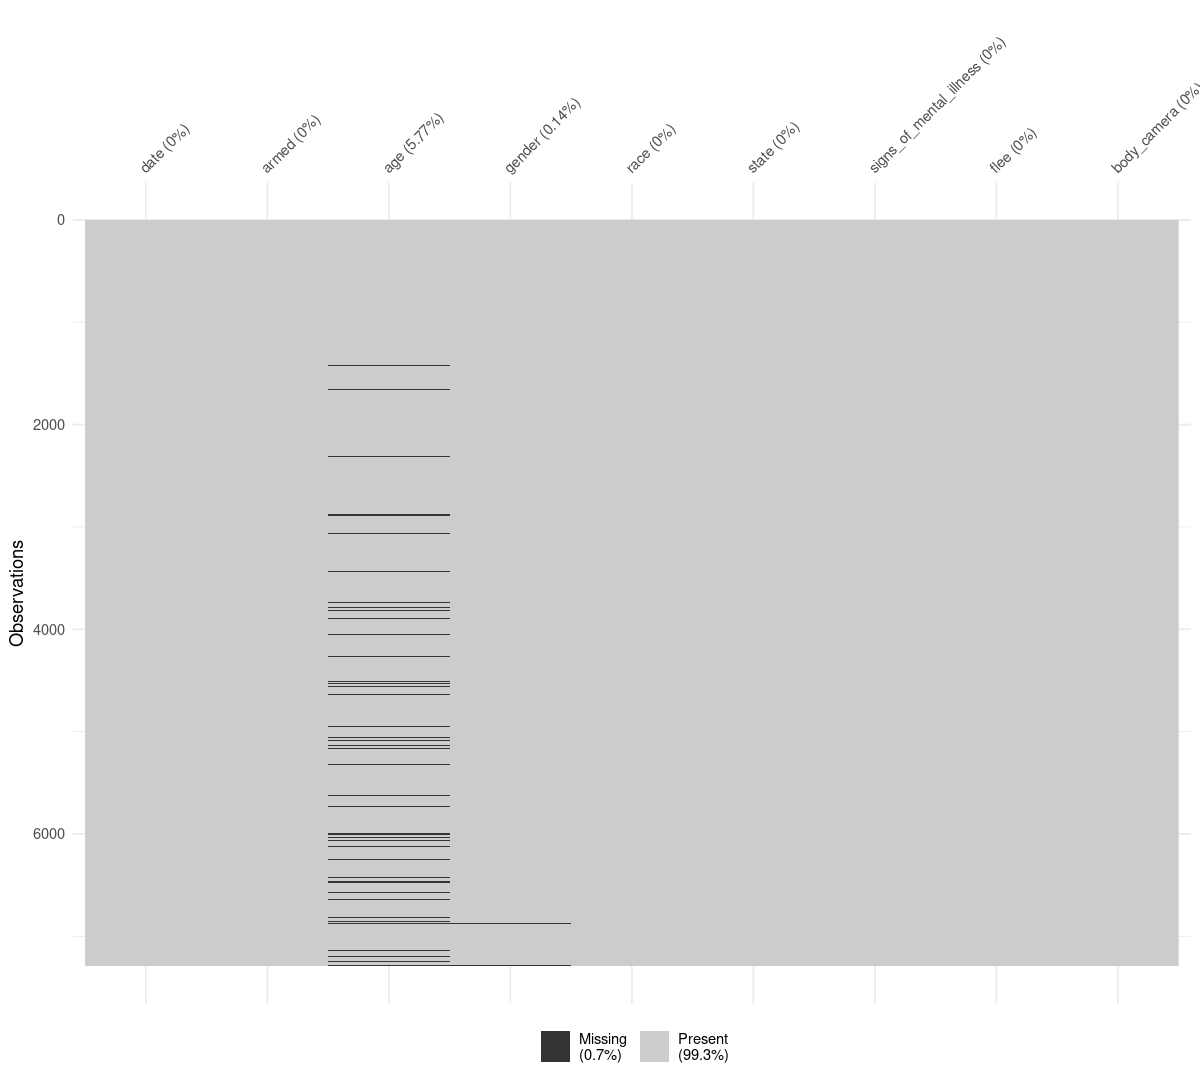

In [11]:
options(repr.plot.width=10, repr.plot.height=9)
vis_miss(data)

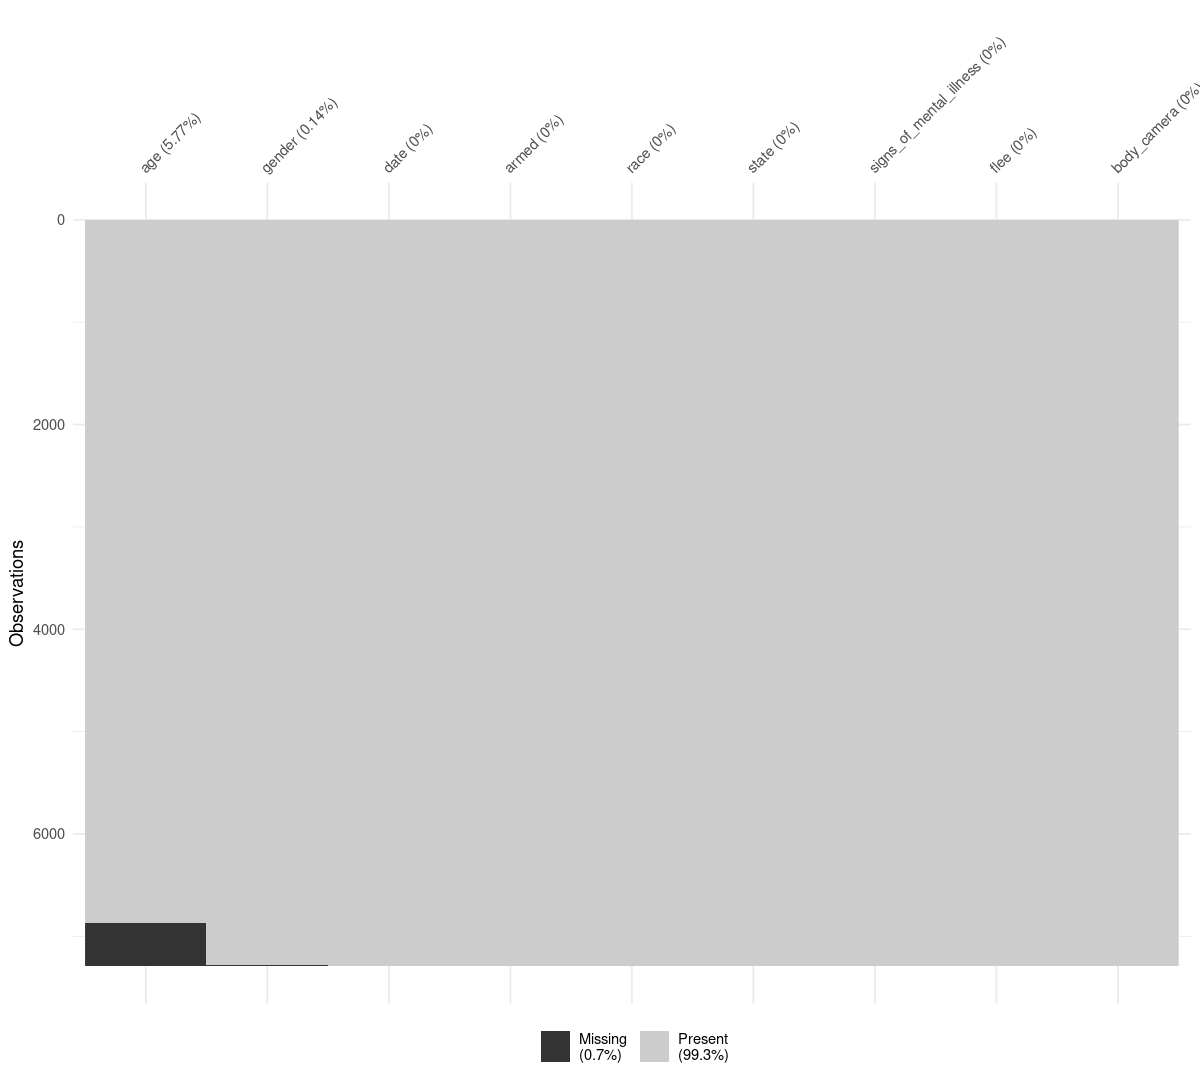

In [12]:
vis_miss(data, cluster = TRUE, sort_miss = TRUE)

In [13]:
summary(data$gender)

F    M NA's 
 330 6951   10

In [14]:
# Drop where gender is NA? The observations are too few in number to add as a category
data = data %>% drop_na(gender)

In [15]:
# Age -> use mean/median imputation?
data$age[is.na(data$age)] <- median(data$age, na.rm = T)

> Missing values have been dealt with, but it would have been a good idea to check if the missingness pattern in age was MCAR/MAR/MNAR

In [16]:
names(data)

[1] "date"                    "armed"                  
[3] "age"                     "gender"                 
[5] "race"                    "state"                  
[7] "signs_of_mental_illness" "flee"                   
[9] "body_camera"

### 3. Evaluation metric & Residual analyses plan

Since this is logistic regression and we are focused on interpretation, it may make sense to look at pure accuracy after using the model weightages as suggested by Alice, to handle the imbalanced nature of the target. Overall, we can consider the following measures:
1. Accuracy
2. AIC
3. AUROC

We should also check that there isn't high linear dependence between the factors using the VIF. `vif(glm.all)`

After models are fitted, check:
1. Histogram of residuals
2. Calibration chart
3. Inspect largest outliers?

### 4. Building model to fit data

In [34]:
library(lme4)
library(splines)

In [20]:
names(data)

[1] "date"                    "armed"                  
[3] "age"                     "gender"                 
[5] "race"                    "state"                  
[7] "signs_of_mental_illness" "flee"                   
[9] "body_camera"

In [32]:
#  1. Run the model selection process on the entire dataset:
#     + start with all features we are considering and build a logistic regression model 
#       (including weights for different classes for outcome, random effects for states, ignoring date etc.)

pos_prop = 1575/(1575 + 5706) # proportion of records where the response variable is positive
neg_prop = 1 - pos_prop
response_weights <- ifelse(data$signs_of_mental_illness == 1, 1/pos_prop, 1/neg_prop)
model_overall <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + age + gender + race + flee +  
    body_camera + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
  8810.2   8927.4  -4388.1   8776.2     7264 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6113 -0.6404 -0.4301 -0.2379  7.6918 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.08182  0.286   
Number of obs: 7281, groups:  state, 51

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -2.712234   0.183277 -14.799  < 2e-16 ***
armedknife         0.625585   0.071773   8.716  < 2e-16 ***
armedother         0.537561   0.073176   7.346 2.04e-13 ***
armedunarmed       0.110753   0.118482   0.935 0.349912    
armedundetermined -0.299836   0.191040  -1.569 0.116533    
armedvehicle      -1.017097  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



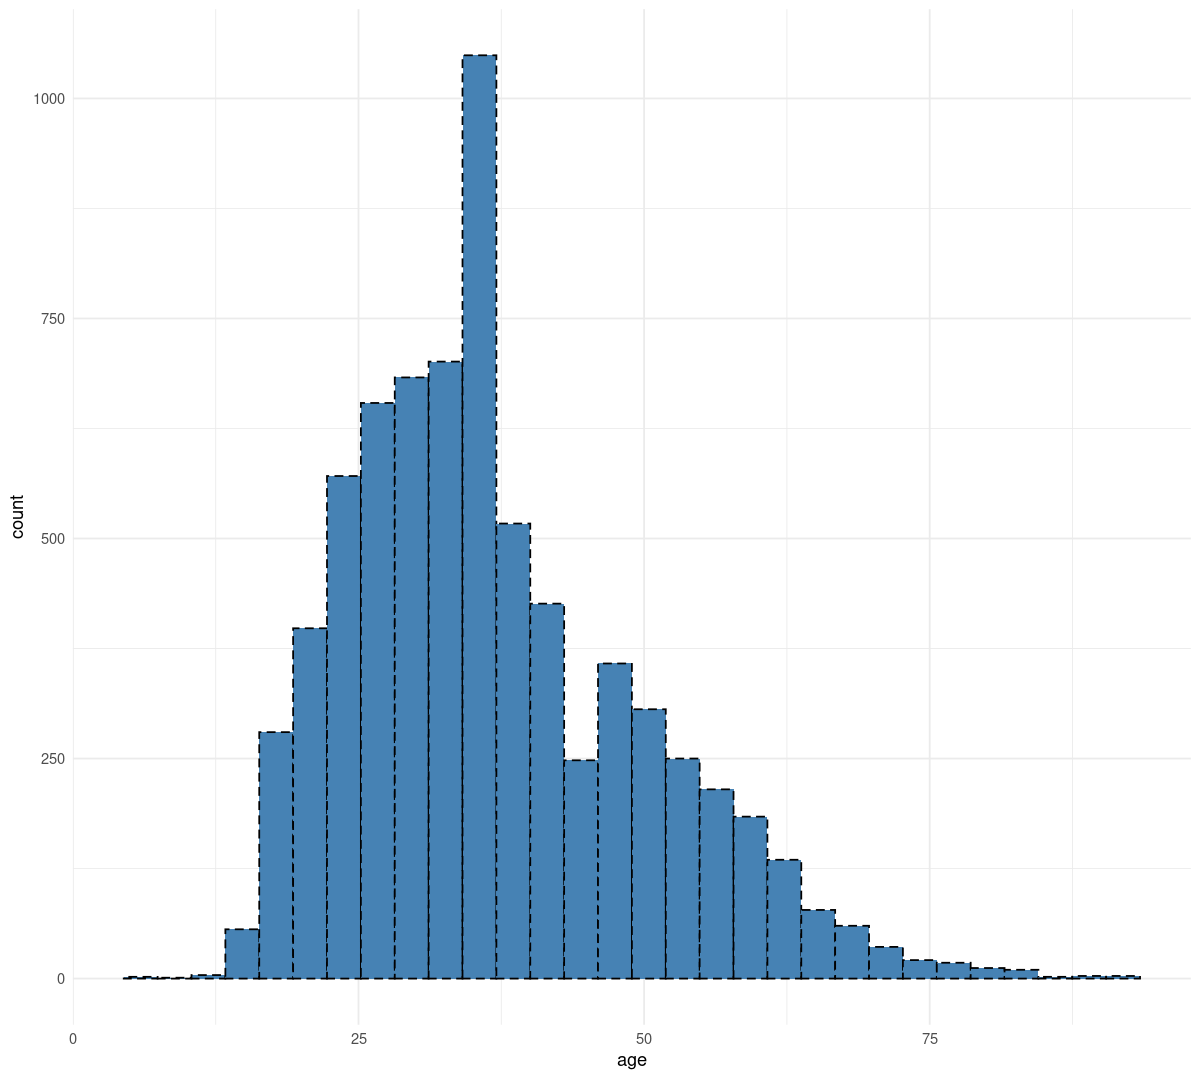

In [31]:
ggplot(data=data, aes(x=age)) + geom_histogram(color="black", fill="steelblue", linetype="dashed") + theme_minimal() + xlab("age")

In [35]:
#     + Experiment with splines and interactions

# Try spline on age
knots.age <- quantile(data$age, c(0.1, 0.3, 0.5, 0.7, 0.9))
model_overall_spline <- glmer(signs_of_mental_illness ~ armed + gender + ns(age, knots=knots.age) + race + flee + body_camera + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_spline)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00380086 (tol = 0.002, component 1)”

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
signs_of_mental_illness ~ armed + gender + ns(age, knots = knots.age) +  
    race + flee + body_camera + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
  8809.8   8961.5  -4382.9   8765.8     7259 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5992 -0.6394 -0.4289 -0.2371  7.7955 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.08254  0.2873  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -4.467565   0.929335  -4.807 1.53e-06 ***
armedknife                   0.633222   0.071958   8.800  < 2e-16 ***
armedother                   0.544970   0.073318   7.433 1.06e-13 ***
armedunarmed                 0.122937   0.118645   1.036 0.300119    
armedundetermin

Adding a spline on age doesn't seem to have brought the AIC down by enough, and the added complexity of interpreting the different interval related coefficient seesm to make it not worth the while of fitting the spline. 

In [36]:
# Consider interactions
model_overall_inter1 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter1)

In [ ]:
#     + Use the evaluation metrics to settle on a final model that we want to stick with, check VIF

In [ ]:
#     + Get a sense of goodness of fit and residuals for this overall model (we may not need this, but might as well do it)

In [18]:
#  2. Once this final model has been decided, split the data into batches by year, and fit the model to each batch individually
#     + Compare coefficients of fitted models across batches to interpret how things are changing/staying the same over time
#     + Also check goodness of fit and residuals for each batch